In [1]:
from __future__ import print_function, division

import os
import pandas as pd
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
nclasses = 14951
learning_rate = 0.0002
batch_size = 100
num_epochs = 10

In [3]:
#for test
learning_rate = 0.0002
batch_size = 100
num_epochs = 10

In [4]:
class LandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.csv_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_data)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 
                                'train', 
                                str(self.csv_data.iloc[idx, 2]), 
                                str(self.csv_data.iloc[idx, 0] + '.jpg'))
        image  = io.imread(img_name)
        label  = torch.from_numpy(self.csv_data.iloc[idx, 2:].as_matrix().astype('long').reshape(-1, 1))
        sample = {'image': image, 'label': label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
}

landmarks_dataset = {
    'train' : LandmarksDataset(csv_file  = 'top5_landmarks_shrunk_train.csv',
                               root_dir  = '/mnt/sw/workspace/Google',
                               transform = data_transforms['train']),
    'val'   : LandmarksDataset(csv_file  = 'top5_landmarks_shrunk_val.csv',
                               root_dir  = '/mnt/sw/workspace/Google',
                               transform = data_transforms['val'])
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation

dataloaders = {
    x: torch.utils.data.DataLoader(landmarks_dataset[x], batch_size = batch_size, shuffle = True, num_workers = 4)
    for x in ['train', 'val']
}

dataset_sizes = { x: len(landmarks_dataset[x]) for x in ['train', 'val'] }

print(dataset_sizes['train'])
print(dataset_sizes['val'])

5000
1278


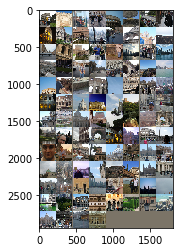

In [7]:
def imshow(inp):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out)

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for sampled_batch in dataloaders[phase]:
                inputs = sampled_batch['image']
                labels = sampled_batch['label']
                inputs = inputs.to(device)
                labels = labels[:, 0, 0].to(device)
                optimizer.zero_grad()
            
            
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
        print
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, nclasses)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr = learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 7, gamma = 0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = num_epochs)

Epoch 1/10
----------
train Loss: 2.2249 Acc: 0.8098
val Loss: 0.3206 Acc: 0.9374
Epoch 2/10
----------
train Loss: 0.1880 Acc: 0.9482
val Loss: 0.0831 Acc: 0.9797
Epoch 3/10
----------
train Loss: 0.1395 Acc: 0.9558
val Loss: 0.0793 Acc: 0.9750
Epoch 4/10
----------
train Loss: 0.1047 Acc: 0.9658
val Loss: 0.0543 Acc: 0.9898
Epoch 5/10
----------
train Loss: 0.0937 Acc: 0.9684
val Loss: 0.0586 Acc: 0.9844
Epoch 6/10
----------
train Loss: 0.0986 Acc: 0.9628
val Loss: 0.0770 Acc: 0.9773
Epoch 7/10
----------
train Loss: 0.0840 Acc: 0.9724
val Loss: 0.0649 Acc: 0.9844
Epoch 8/10
----------
train Loss: 0.0689 Acc: 0.9778
val Loss: 0.0532 Acc: 0.9875
Epoch 9/10
----------
train Loss: 0.0560 Acc: 0.9824
val Loss: 0.0428 Acc: 0.9906
Epoch 10/10
----------
train Loss: 0.0726 Acc: 0.9744
val Loss: 0.0402 Acc: 0.9883
Training complete in 14m 35s
Best val Acc: 0.990610


In [11]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, sampled_batch in enumerate(dataloaders['val']):
        inputs = sampled_batch['image']
        labels = sampled_batch['label']
        inputs = inputs.to(device)
        labels = labels[:, 0, 0].to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('Predicted: {}'.format(preds[j]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

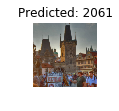

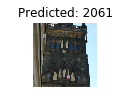

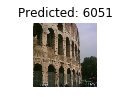

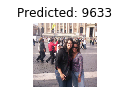

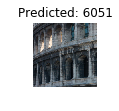

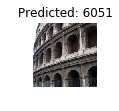

In [12]:
visualize_model(model_ft)